In [2]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd


from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split


import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

## set paths and conditions

In [3]:
save_data = True

delete_top_numFSP_evts=True

In [4]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/"

In [5]:
data_savedir = "data/Bsig_isSig1/"
rawData_subdir = "onlineRawData/Bsig_isSig1/"  

## load the raw data

In [52]:
fileFSPs = uproot.open(nfs_path + rawData_subdir + "FSPs.root:variables")

In [53]:
df_FSPs = fileFSPs.arrays(library="pd")
df_FSPs.shape[0]

2441440

In [50]:
Bsig_cand_File = uproot.open(nfs_path + rawData_subdir +  "Bsig_cand.root:variables")

In [54]:
Bsig_cand_df = Bsig_cand_File.arrays(library="pd")
Bsig_cand_df.shape[0]

213977

## overview of data properties

In [55]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]
#df_FSPs.groupby(["uniqueParticleIdentifier",'__event__', '__production__']).ngroups

print("FSPs per event:", round(FSPs_noDuplis.shape[0] / FSPs_noDuplis["__event__"].nunique(), 2))
print("non Bsig FSPs per event:", round(nonBsig_FSPs.shape[0] / nonBsig_FSPs["__event__"].nunique(), 2))

FSPs per event: 11.42
non Bsig FSPs per event: 8.14


<AxesSubplot:>

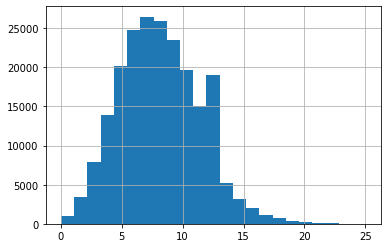

In [56]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs["numFSPs"].hist(bins=bins)

In [57]:
Bsig_cand_df['Bsig_isSignal'].mean()

1.0

In [58]:
Bsig_cand_df.shape[0]

213977

# pre selection and labeling

### delete FSP duplicates and Bsig descendants

In [59]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]

### which B is Bsig? and is it the real D*lv one?

In [60]:
Bsig_cand_df['Bsig_uniqParID'] = Bsig_cand_df.apply(whichBisSig_NAHS, axis=1)

In [61]:
Bsig_cand_df['Bsig_uniqParID'].value_counts()

83886081.0    121083
83886082.0     92894
Name: Bsig_uniqParID, dtype: int64

### label and filter D0 modes

In [62]:
Bsig_cand_df['D0_decay'] = Bsig_cand_df.apply(D0_decay_type, axis=1)

In [63]:
Bsig_cand_df['D0_decay'].value_counts()

Kpipi0        77910
Kpi           71053
notWanted     48417
Kpipipi       15055
Kpipipipi0     1542
Name: D0_decay, dtype: int64

In [105]:
Bsig_cand_df = Bsig_cand_df[Bsig_cand_df['D0_decay'] != "notWanted"]
Bsig_cand_df.shape[0]

109902

In [107]:
print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())


nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(Bsig_cand_df["__event__"])]


print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())

1039115
132863
860640
109901


## label FSPs

In [65]:
print(nonBsig_FSPs.shape[0])
nonBsig_FSPs = pd.merge(nonBsig_FSPs, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(nonBsig_FSPs.shape[0])

1738670
1741915


In [66]:
nonBsig_FSPs['B_ID'] = nonBsig_FSPs.apply(B_ID, axis=1)

In [67]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        B_sigID = s['Bsig_uniqParID']
        
        if int(s['B_ID']) == B_sigID:
            label = 2 # Bsig
        else:
            label = 1 # Btag
    return label

In [68]:
nonBsig_FSPs['label'] = nonBsig_FSPs.apply(labels, axis=1)

In [69]:
nonBsig_FSPs['label'].value_counts()

1    1200701
0     391619
2     149595
Name: label, dtype: int64

In [70]:
nonBsig_FSPs['label'].value_counts(normalize=True)

1    0.689299
0    0.224821
2    0.085880
Name: label, dtype: float64

## new step: only for Bsig isSig==1, check which evts still have label==2, despite Bsig isSig==1

In [73]:
label2_FSPs = nonBsig_FSPs[nonBsig_FSPs['label']==2]

In [74]:
TMP_nonLabel2_FSPs = nonBsig_FSPs[~nonBsig_FSPs['__event__'].isin(label2_FSPs["__event__"])]

In [75]:
TMP_nonLabel2_FSPs["label"].value_counts()

1    799956
0    243498
Name: label, dtype: int64

In [76]:
TMP_nonLabel2_FSPs["__event__"].nunique()

133055

In [77]:
Bsig_cand_df_tmp = Bsig_cand_df[Bsig_cand_df['__event__'].isin(TMP_nonLabel2_FSPs["__event__"])]

In [78]:
Bsig_cand_df_tmp.shape[0]

133100

In [80]:
Bsig_cand_df_tmp['D0_decay'].value_counts()

Kpipi0        53082
Kpi           47187
notWanted     23004
Kpipipi        8974
Kpipipipi0      853
Name: D0_decay, dtype: int64

In [81]:
Bsig_cand_df = Bsig_cand_df_tmp
nonBsig_FSPs = TMP_nonLabel2_FSPs

### check max num FSPs per event

<AxesSubplot:>

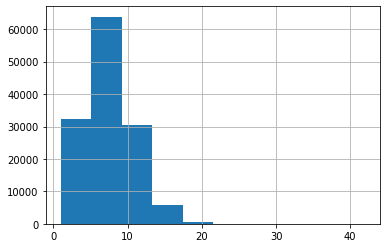

In [82]:
numberFSPsEvts = pd.DataFrame({'count' : nonBsig_FSPs.groupby(["__event__"]).size()}).reset_index()
numberFSPsEvts['count'].hist()

In [83]:
numberFSPsEvts['count'].max()

42

## delete delete_top_numFSP_evts

In [87]:
# print first to adjust percentile used
print("original max FSPs:",numberFSPsEvts["count"].max())
for percentile_lvl in [0.995,0.996,0.997,0.998,0.999]:
    print(percentile_lvl)
    percentile = numberFSPsEvts["count"].quantile(q=percentile_lvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    #TMP_df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    TMP_nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
    print("would delete", round(100 - (TMP_nonBsig_FSPs.shape[0]/TMP_nonBsig_FSPs.shape[0])*100,6),"% of evts")
    print("new max FSPs:",cut_numberFSPsEvts["count"].max())

original max FSPs: 42
0.995
would delete 0.0 % of evts
new max FSPs: 17
0.996
would delete 0.0 % of evts
new max FSPs: 17
0.997
would delete 0.0 % of evts
new max FSPs: 17
0.998
would delete 0.0 % of evts
new max FSPs: 18
0.999
would delete 0.0 % of evts
new max FSPs: 19


In [88]:
print(nonBsig_FSPs.shape[0])
print(Bsig_cand_df.shape[0])
numEvtsBeforeCut = nonBsig_FSPs.shape[0]

if delete_top_numFSP_evts:
    delete_percentileLvl = 0.999
    print("used delete_percentileLvl:",delete_percentileLvl)
    
    
    print(numberFSPsEvts["count"].describe())
    
    percentile = numberFSPsEvts["count"].quantile(q=delete_percentileLvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    Bsig_cand_df = Bsig_cand_df[Bsig_cand_df['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
print(nonBsig_FSPs.shape[0])
print(Bsig_cand_df.shape[0])
print("deleted", round(100 - (nonBsig_FSPs.shape[0]/numEvtsBeforeCut)*100,4),"% of events")
numberFSPsEvts = pd.DataFrame({'count' : nonBsig_FSPs.groupby(["__event__"]).size()}).reset_index()
print(numberFSPsEvts["count"].describe())

1043454
133100
used delete_percentileLvl: 0.999
count    133055.000000
mean          7.842276
std           3.182363
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          42.000000
Name: count, dtype: float64
1039115
132865
deleted 0.4158 % of events
count    132863.000000
mean          7.820951
std           3.129894
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          19.000000
Name: count, dtype: float64


### impute the nan values of variables

In [89]:
## data preprocessing, dealing with NaN
imputelist = [["pionID",-1.],["kaonID",-1.],["electronID",-1.],["muonID",-1.],["protonID",-1.]
              ,["clusterReg",-1.],["clusterE9E21",-1.]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])    
    mask = nonBsig_FSPs[column_name].isna() == 1
    nonBsig_FSPs.loc[mask, column_name] = impute_val
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])

792264
0
792264
0
792264
0


/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

792264
0
792264
0
21777
0
21777
0


/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### check that each particles occurs only ones; count must be == 1 for all

In [90]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    2439996
2        722
dtype: int64

## save & load labeled and processed df's

### save

In [109]:
nonBsig_FSPs.to_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")
Bsig_cand_df.to_csv(nfs_path + "Bsig_cand_df_preProcessed.csv")

In [110]:
print("save successful")

save successful


### load

In [6]:
nonBsig_FSPs = pd.read_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")

In [ ]:
Bsig_cand_df = pd.read_csv(nfs_path + rawData_subdir +  "Bsig_cand_df_preProcessed.csv")

In [11]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 5)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

49239

<AxesSubplot:>

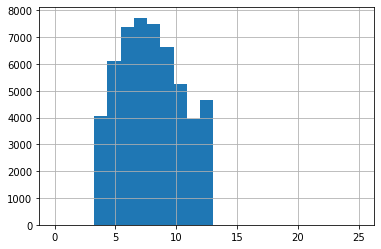

In [15]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)]["numFSPs"].hist(bins=bins)

In [14]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

53314

<AxesSubplot:>

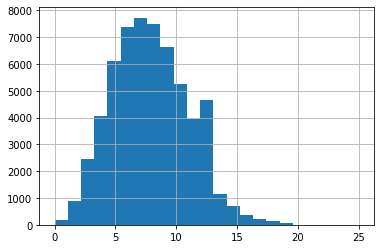

In [12]:
numberOfFSPs["numFSPs"].hist(bins=bins)

# beginning of data prod

In [111]:
df_FSPs_final = nonBsig_FSPs

## definition of input vars to be saved

In [112]:
variable_combinations = [
    [[],"caupi_only4mom"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_allExtras"],
    [["charge","dr","clusterE9E21"],"caupi_chrg_dr_E9E21"],
    [[    "charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_M"],
    [["M",         "dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_charge"],
    [["M","charge",     "dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dr"],
    [["M","charge","dr",     "clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dz"],
    [["M","charge","dr","dz",             "clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_clReg"],
    [["M","charge","dr","dz","clusterReg",               "pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_E9E21"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21",         "kaonID","electronID","muonID","protonID",
     ],"caupi_no_pID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID",         "electronID","muonID","protonID",
     ],"caupi_no_kID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID",             "muonID","protonID",
     ],"caupi_no_eID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID"         ,"protonID",
     ],"caupi_no_muID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID"           ,
     ],"caupi_no_proID"],
    [["charge","pionID","muonID",],"caupi_charge_mpIDs"],
    [["charge"],"caupi_charge"]
]

In [113]:
len(variable_combinations)

16

## start of saving

In [114]:
numFSPs = pd.DataFrame({'count' : df_FSPs_final.groupby( ["__event__"] ).size()}).reset_index()

minFSPs = numFSPs["count"].min()
maxFSPs = numFSPs["count"].max()
print("minFSPs:",minFSPs)
print("maxFSPs:",maxFSPs,'\n')
print("num Events:",numFSPs.shape[0],'\n')

df_FSPs_final['numFSPs'] = df_FSPs_final.groupby('__event__')['__event__'].transform('count')

minFSPs: 1
maxFSPs: 19 

num Events: 59514 



In [115]:
now = datetime.now()
print("time at start =", now)

time at start = 2022-01-28 20:48:42.831244


In [116]:
save_data

True

In [ ]:
minFSPs = 2 # minimum: Btag: 2 particles
for var_comb in variable_combinations:
    ablationSub = var_comb[1]
    data_dir = Path(nfs_path + data_savedir + "/" + ablationSub + "/")    
    if save_data:
        data_dir.mkdir(parents=True, exist_ok=True)
    print("Will save data to:", data_dir,'is', save_data ,'\n')


    
    for num_FSPs_toData in range(minFSPs, maxFSPs+1):
        df_num_subset = df_FSPs_final.copy()
        df_num_subset = df_num_subset[df_num_subset['numFSPs'] == num_FSPs_toData]


        numEvents = df_num_subset.__event__.nunique()
        print("numEvents:",numEvents)
        print("num_FSPs_toData:",num_FSPs_toData)  
        if numEvents == 0:
            print("skipped because empty \n")
            continue

        if numEvents < 10:
            print("skipped because <10 events \n")
            continue

        num_features = 4 + len(var_comb[0])
        leaves = np.zeros((numEvents, num_FSPs_toData,  num_features))  
        SA_target =  np.zeros((numEvents, num_FSPs_toData))
        global_tag = np.chararray((numEvents, num_FSPs_toData + 1), itemsize=30)

        event_list = df_num_subset[df_num_subset["numFSPs"] == num_FSPs_toData]["__event__"].unique()
        #print("len(event_list):",len(event_list))
        for i in range(numEvents):

            event_iter = event_list[i]

            global_tag_masterInfo = "evt" + str(event_iter)
            global_tag[i,-1] = global_tag_masterInfo
            #print("global_tag[i,-1]:",global_tag[i,-1])
            #print("i:",i,"event_iter:",event_iter)

            event_df = df_num_subset[df_num_subset.__event__ == event_iter]

            for j in range(num_FSPs_toData):
                #print("numParticle:",j)
                particle = event_df.iloc[j]

                #print(particle["mcPDG"],particle["px"],particle["py"],particle["pz"],particle["E"])
                leaves[i,j,0] = particle["px"]
                leaves[i,j,1] = particle["py"]
                leaves[i,j,2] = particle["pz"]
                leaves[i,j,3] = particle["E"]
                
                for k in range(len(var_comb[0])):
                    leav_idx = k + 4
                    leaves[i,j,leav_idx] = particle[var_comb[0][k]]
                    



                global_tag_Info = str((particle["mcPDG"])) 
                global_tag[i,j] = global_tag_Info

        
                SA_target[i,j] = particle["label"]

            del event_df


        # shuffle the data    
        for idx in np.arange(leaves.shape[0]):   # arange is like range but gives ndarray instead of list
            perms = np.random.permutation(leaves.shape[1])

            leaves[idx,:] = leaves[idx,perms]
            SA_target[idx,:] = SA_target[idx,perms]
            global_tag[idx,0:-1] = global_tag[idx,perms]





        #print(global_tag)
        train_ratio = 0.8
        validation_ratio = 0.2
        #test_ratio = 0.1

        print("leaves.shape:",leaves.shape)
        print("SA_target.shape:",SA_target.shape)
        print("global_tag.shape:",global_tag.shape)


        print("leaves[0]:",leaves[0])
        print("SA_target[0]:",SA_target[0])
        print("global_tag[0]:",global_tag[0])

        x=leaves
        y=SA_target
        z=global_tag

        x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(x_test, y_test, z_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 

        if save_data==True:
            np.save(data_dir / "leaves_train_FSP{}.npy".format(num_FSPs_toData), x_train)
            np.save(data_dir / "is_left_arr_train_FSP{}.npy".format(num_FSPs_toData), y_train)
            np.save(data_dir / "global_tag_train_FSP{}.npy".format(num_FSPs_toData), z_train)

            np.save(data_dir / "leaves_val_FSP{}.npy".format(num_FSPs_toData), x_val)
            np.save(data_dir / "is_left_arr_val_FSP{}.npy".format(num_FSPs_toData), y_val)
            np.save(data_dir / "global_tag_val_FSP{}.npy".format(num_FSPs_toData), z_val)

            #np.save(data_dir / "leaves_test_FSP{}.npy".format(num_FSPs_toData), x_test)
            #np.save(data_dir / "is_left_arr_test_FSP{}.npy".format(num_FSPs_toData), y_test)
            #np.save(data_dir / "global_tag_test_FSP{}.npy".format(num_FSPs_toData), z_test)


        print("")


        del df_num_subset


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/Bsig_isSig1/caupi_only4mom is True 

numEvents: 880
num_FSPs_toData: 2
leaves.shape: (880, 2, 4)
SA_target.shape: (880, 2)
global_tag.shape: (880, 3)
leaves[0]: [[ 0.48801678 -0.37948602  0.67160851  1.0377596 ]
 [ 0.07662224 -0.14136499  0.1637796   0.2295186 ]]
SA_target[0]: [1. 0.]
global_tag[0]: [b'-321.0' b'nan' b'evt354552']

numEvents: 2456
num_FSPs_toData: 3
leaves.shape: (2456, 3, 4)
SA_target.shape: (2456, 3)
global_tag.shape: (2456, 4)
leaves[0]: [[-0.01414753  0.02164434  0.07378036  0.07818038]
 [-0.18539055  0.49315667  1.42012846  1.51470724]
 [ 0.14423987  0.32583258 -0.02796469  0.60948421]]
SA_target[0]: [0. 1. 1.]
global_tag[0]: [b'nan' b'22.0' b'-211.0' b'evt3680894']

numEvents: 4075
num_FSPs_toData: 4
leaves.shape: (4075, 4, 4)
SA_target.shape: (4075, 4)
global_tag.shape: (4075, 5)
leaves[0]: [[ 0.43934    -0.51771712 -0.06711557  0.69644457]
 [ 1.15616906 -0.05132571  0.5180276   1


numEvents: 1150
num_FSPs_toData: 14
leaves.shape: (1150, 14, 4)
SA_target.shape: (1150, 14)
global_tag.shape: (1150, 15)
leaves[0]: [[ 0.02727498  0.01165743  0.05303084  0.06076257]
 [ 0.05298585  0.02537317  0.07253508  0.0933415 ]
 [-0.00885411 -0.05358255  0.04081906  0.0679388 ]
 [-0.07499092  0.08623031  0.01712751  0.11555369]
 [-0.97411221  0.5907169  -0.05464669  1.14053817]
 [-0.02166902  0.00381156 -0.026566    0.03449386]
 [ 0.1987882  -0.5435937   0.36237231  0.84263962]
 [-0.0113273  -0.03282306  0.02348863  0.04192108]
 [ 0.3213658  -0.57631516  0.69644773  1.34194227]
 [ 0.33933976  0.01610216  0.06899811  0.3466576 ]
 [ 0.18735009 -0.3109822   0.05999712  0.36798049]
 [ 0.16661799 -0.10002281  0.02955383  0.19656944]
 [-0.0617203  -0.00897871 -0.0055974   0.06262064]
 [ 0.06703683  0.02552936  0.16035317  0.1756668 ]]
SA_target[0]: [0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.]
global_tag[0]: [b'nan' b'22.0' b'22.0' b'22.0' b'22.0' b'nan' b'321.0' b'nan' b'-321.0'
 b'22.

leaves.shape: (880, 2, 15)
SA_target.shape: (880, 2)
global_tag.shape: (880, 3)
leaves[0]: [[ 7.66222402e-02 -1.41364992e-01  1.63779601e-01  2.29518597e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 4.88016784e-01 -3.79486024e-01  6.71608508e-01  1.03775960e+00
   4.93676990e-01 -1.00000000e+00  2.35286168e-03  2.26462343e-02
   2.00000000e+00  9.55078125e-01  1.27901329e-17  1.00000000e+00
   3.41348795e-13  2.10340184e-17  2.74405510e-39]]
SA_target[0]: [0. 1.]
global_tag[0]: [b'nan' b'-321.0' b'evt354552']

numEvents: 2456
num_FSPs_toData: 3
leaves.shape: (2456, 3, 15)
SA_target.shape: (2456, 3)
global_tag.shape: (2456, 4)
leaves[0]: [[-1.85390547e-01  4.93156672e-01  1.42012846e+00  1.51470724e+00
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.84375000e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000


numEvents: 6635
num_FSPs_toData: 9


In [ ]:
print("saving is done")
now = datetime.now()
print("time at end =", now)

## additional analysis on Bsig correctness

In [19]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')

In [20]:
FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(Bsig_cand_df["__event__"])]

In [21]:
FSPs_noDuplis['B_ID'] = FSPs_noDuplis.apply(B_ID, axis=1)

In [22]:
FSPs_noDuplis['B_ID'].value_counts()

83886082    2088965
83886081    2081963
0            763802
Name: B_ID, dtype: int64

In [23]:
print(FSPs_noDuplis.shape[0])
FSPs_noDuplis = pd.merge(FSPs_noDuplis, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(FSPs_noDuplis.shape[0])

4934730
4934730


In [24]:
FSPs_noDuplis["genBsig_descendant"] = (FSPs_noDuplis["B_ID"] == FSPs_noDuplis["Bsig_uniqParID"]).astype(int)

In [25]:
FSPs_noDuplis['genBsig_descendant'].describe()

count    4.934730e+06
mean     2.998267e-01
std      4.581820e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64

In [26]:
Bsig_cand_df["Bsig_genParticleID"].value_counts()

0.0    220628
1.0     31483
2.0     28070
Name: Bsig_genParticleID, dtype: int64

In [27]:
genBsigs = pd.DataFrame({'count' : Bsig_cand_df.groupby( ["Bsig_genParticleID","Bsig_uniqParID"] ).size()}).reset_index()
genBsigs

,Bsig_genParticleID,Bsig_uniqParID,count
0,0.0,83886081.0,115373
1,0.0,83886082.0,105255
2,1.0,83886081.0,31239
3,1.0,83886082.0,244
4,2.0,83886081.0,1167
5,2.0,83886082.0,26903


In [28]:
tmp = Bsig_cand_df[((((Bsig_cand_df["Bsig_genParticleID"] == 1.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886081.0))) | 
                   ((Bsig_cand_df["Bsig_genParticleID"] == 2.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886082.0)))]
print(tmp.shape[0])

tmpFSPs = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(tmp["__event__"])]


tmpFSPs['genBsig_descendant'].describe()

58142


count    674085.000000
mean          0.325314
std           0.468492
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: genBsig_descendant, dtype: float64

In [29]:
Bsig_correctness = pd.DataFrame({'count' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size(),
                            'fraction' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size()/FSPs_noDuplis.shape[0]}).reset_index()
Bsig_correctness

,genBsig_descendant,Bsig_used,count,fraction
0,0,0.0,3079555,0.624057
1,0,1.0,375611,0.076116
2,1,0.0,694162,0.140669
3,1,1.0,785402,0.159158


In [ ]:
tmpFSPs['label'] = tmpFSPs.apply(labels, axis=1)

In [32]:
## genBsig descendants only for Bsig used each

print(FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 1]['genBsig_descendant'].describe())

print(tmpFSPs[tmpFSPs["Bsig_used"] == 1]['genBsig_descendant'].describe())
print(tmpFSPs[tmpFSPs["label"] == 2]['genBsig_descendant'].describe())

# the tmpFSPs is probably close to isSig==1, otherwise the Bsig_genParticleID wouldnt be 1 or 2

count    1.161013e+06
mean     6.764799e-01
std      4.678194e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64
count    190223.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64
count    219289.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
